# Evaluating Image to Text Models


In [29]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from src.evaluation.eval_main import Metrics

folder_path = "../../../eval_results/apple_vqg"

In [2]:
gt_df = pd.read_csv(os.path.join(folder_path, "224x224-dense-glove-greedy-image-only-master/gt_apple_vqg_test.csv"))
res_df = pd.read_csv(os.path.join(folder_path, "224x224-dense-glove-greedy-image-only-master/result_apple_vqg_test.csv"))
gt_df

,image_id,questions
0,1,how can words be counted with mapreduce
1,2,describe the rdd workflow---how does the rdd w...
2,3,what are key aspects and differences of the ki...
3,4,what are the communication costs for semi join...
4,5,what is a merkle tree---why is the merkle tree...
...,...,...
453,454,which transformations exist in spark
454,455,what is the internal structure of the formula ...
455,456,what are the two approaches to input domain mo...
456,457,how does the ranking work when relevance judge...


In [3]:
res_df

,image_id,image_url,questions
0,1,datasets/master/images/large_scale_combined_22...,what
1,2,datasets/master/images/large_scale_combined_32...,NaN
2,3,datasets/master/images/leadership_combined_16.png,the the the the the the the the the the the th...
3,4,datasets/master/images/large_scale_combined_19...,NaN
4,5,datasets/master/images/large_scale_combined_54...,NaN
...,...,...,...
453,454,datasets/master/images/large_scale_combined_33...,what
454,455,datasets/master/images/decision_support_combin...,NaN
455,456,datasets/master/images/ase_combined_112.png,NaN
456,457,datasets/master/images/information_retrieval_c...,NaN


## Explaining the model names

### Apple VQG
- All the following concepts have to be explained / layed out
- original paper: [ref](https://arxiv.org/pdf/2012.03678.pdf)
- Supports multiple different image encoders, resolutions and inputs
- first part: resolution, e.g. 224x224
- second part: Image Encoders:
    - dense: DenseNet [ref](https://arxiv.org/abs/1608.06993)
    - vgg19: VGG19 [ref](https://arxiv.org/abs/1608.06993)
    - They are initialized from pre-trained weights from the model hub -> Trained on COCO / ImageNet
- third part: Embedding strategy:
    - I only used the Glove embeddings as they performed the best in the original apple paper
- fourth part: inputs:
    - Image only: No further text input only the image encoder as context
    - Keywords: Image and Keyword input, in our case, keyword = title of the slide
- fifth part: decoding strategy:
    - greedy: Always select the token with the highest probability [ref](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24)
    - sbs: Simple Beam Search: [ref](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24)
- The LSTMs are initialized without pre-trained weights and are trained from scratch, as the apple guys didn't release any pre-trained weights
- Model sketch: (the one in the paper is misleading)
![Apple VQG sketch](Ankinator%20Concept-4.jpg)

- Model is trained with different configurations:
- DenseNet and VGG19 to see if different image encoder architectures might cope better with the slide data or can be fine-tuned faster to yield meaningful encodings
- Different Decoding Schemes: Greedy and Simple Beam Search
    - Using Beam Search takes significantly longer, but in theory should yield a better performance as the result sequence is evaluated and not the probability of the individual tokens
- With Keywords and without, to capture the impact of feeding keywords to the model
- With the original resolution of 224x224 because thats what the models have been pretrained for and what the model was originally proposed with
    - This was expected to yield bad performance numbers as text is very sensitive to resolution -> show this with an example where a high res image and a low res one are side by side and point out visual differences
- And in fhd, as it is returned by the extractor to solve the resolution issue

## Visualizing the number of NaN Values the model produces
- Visualize the number of NaN values produced per model
- The model producing NaN = No output / it only produced an \<end>-token -> No question has been generated

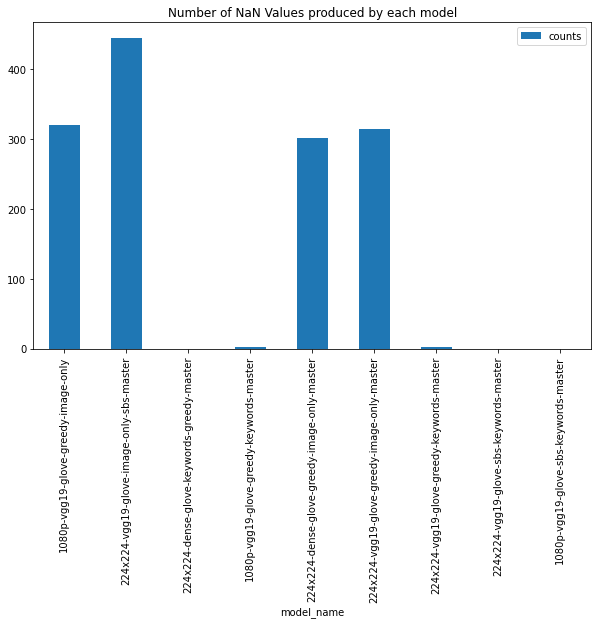

In [45]:
from collections import defaultdict

dir_content = os.listdir(folder_path)
dir_content.remove(".DS_Store")

nan_cnts = defaultdict(list)

for folder in dir_content:
    tmp_res_df = pd.read_csv(
        os.path.join(
            os.path.join(folder_path, folder),
            "result_apple_vqg_test.csv"
        )
    )
    nan_cnts["model_name"].append(folder)
    nan_cnts["counts"].append(tmp_res_df.questions.isnull().sum())

pd.DataFrame(nan_cnts).plot(kind='bar', x="model_name", figsize=(10, 6))
plt.title('Number of NaN Values produced by each model')
plt.show()

- Using Greedy or Simple Beam Search (sbs) makes no difference in the number of NaN values produced by the model
- Using a higher resolution also doesn't improve the number of NaN values
- However, enabling the use of Keywords as input, drastically reduces the number of cases where the model produces NaN values
    - Number of NaN values is then almost 0
    - The Image Encoder seemed to have no effect for the resolution of 224x224, combined with the fact that keywords drastically influence the number of produced outputs, it shows that the image encoder produces no usable information at this resolution
    - I'd add an example from the extracted image and the rescaled image at some point into the report, as it is important for both vit-gpt2 and the apple_vqg model

## Applying evaluation

In [46]:
dir_content = os.listdir(folder_path)
dir_content.remove(".DS_Store")

overall = pd.DataFrame()

for folder in dir_content:
    # read ground truth
    gt_df = pd.read_csv(
        os.path.join(
            os.path.join(folder_path, folder),
            "gt_apple_vqg_test.csv"
        )
    )
    # read model outs
    res_df = pd.read_csv(
        os.path.join(
            os.path.join(folder_path, folder),
            "result_apple_vqg_test.csv"
        )
    )
    # convert multiple reference format of the apple model to list
    gt_df["questions"] = gt_df.questions.apply(lambda str: str.split("---"))

    # build reference data representation
    refs = []
    for idx, row in gt_df.iterrows():
        refs.append((row.image_id, row.questions))

    # build model output representation
    model_outs = []
    res_df["questions"] = res_df.questions.fillna("") # change nan to empty string, as nan is a floating value
    for idx, row in res_df.iterrows():
        model_outs.append((row.image_id, [row.questions]))

    # run evaluation
    metrics = Metrics(save_to_file=True)
    result = pd.DataFrame(
        metrics.evaluate(model_output=model_outs, references=refs),
        index=[folder]
    )
    result.to_csv("out/eval/result.csv")

    overall = pd.concat([overall, result])

    # copy results to correct folder
    os.system(f"mv out/eval/* {os.path.join(folder_path, folder)}")




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I516998/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I516998/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I516998/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I516998/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I516998/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I516998/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I516998/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I516998/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I516998/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
overall

,CASING,GRAMMAR,rouge1_fmeasure,rouge1_precision,rouge1_recall,rouge2_fmeasure,rouge2_precision,rouge2_recall,rougeL_fmeasure,rougeL_precision,...,avg_f1,max_f1,min_f1,avg_cos_sim,max_cos_sim,min_cos_sim,avg_sem_meteor,max_sem_meteor,min_sem_meteor,MISC
1080p-vgg19-glove-greedy-image-only,23,75.0,0.031657,0.120005,0.019948,0.000190,0.000136,0.000312,0.031657,0.120005,...,0.0,0,0,0.034937,0.221093,-0.126716,0.010650,0.178571,0.0,NaN
224x224-vgg19-glove-image-only-sbs-master,4,48.0,0.001853,0.004201,0.001536,0.000000,0.000000,0.000000,0.001853,0.004201,...,0.0,0,0,0.028281,0.201712,-0.126716,0.000772,0.104167,0.0,NaN
224x224-dense-glove-keywords-greedy-master,458,NaN,0.186232,0.287664,0.144735,0.047149,0.077147,0.035493,0.184147,0.283297,...,0.0,0,0,0.063235,0.241541,-0.116783,0.093057,0.440613,0.0,458.0
1080p-vgg19-glove-greedy-keywords-master,456,NaN,0.198215,0.425764,0.134611,0.071256,0.208515,0.045455,0.197681,0.423945,...,0.0,0,0,0.123643,0.334309,-0.078710,0.109258,0.646552,0.0,NaN
224x224-dense-glove-greedy-image-only-master,39,311.0,0.035904,0.122273,0.028263,0.000000,0.000000,0.000000,0.035904,0.122273,...,0.0,0,0,0.038929,0.204483,-0.088190,0.014107,0.172414,0.0,3.0
224x224-vgg19-glove-greedy-image-only-master,49,558.0,0.018857,0.045167,0.018977,0.000000,0.000000,0.000000,0.018857,0.045167,...,0.0,0,0,0.033841,0.201712,-0.126716,0.008921,0.135135,0.0,4.0
224x224-vgg19-glove-greedy-keywords-master,455,16.0,0.156418,0.281391,0.113094,0.017558,0.036572,0.012128,0.154620,0.277140,...,0.0,0,0,0.069930,0.261625,-0.076397,0.070536,0.516569,0.0,18.0
224x224-vgg19-glove-sbs-keywords-master,457,8.0,0.173148,0.402177,0.115575,0.061745,0.201965,0.038601,0.172905,0.401085,...,0.0,0,0,0.120763,0.399330,-0.078710,0.094612,0.646552,0.0,4.0
1080p-vgg19-glove-sbs-keywords-master,456,16.0,0.176810,0.411572,0.117397,0.065571,0.211790,0.040785,0.176567,0.410480,...,0.0,0,0,0.123014,0.399330,-0.078710,0.097842,0.646552,0.0,NaN


## Evaluation Metrics

### Similiarity

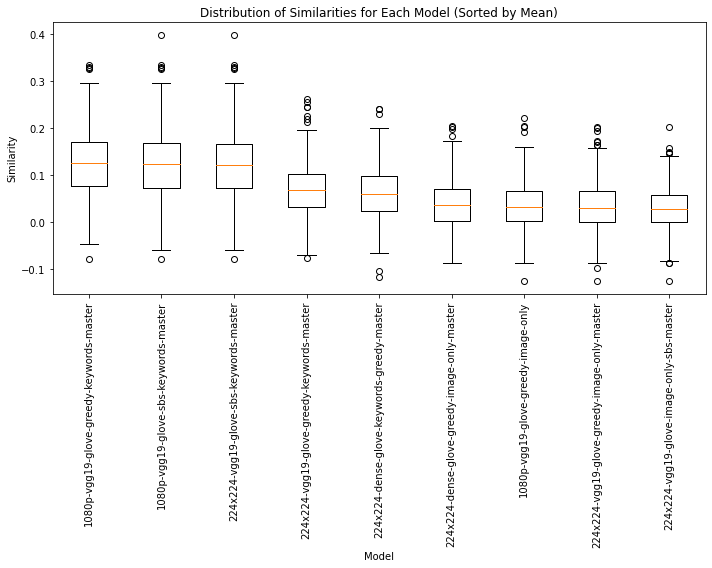

In [49]:
# Initialize a list to store the similarity data for each model
similarity_data = []

# Iterate through the subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        csv_path = os.path.join(subfolder_path, "cosine_sim.csv")

        # Check if the cosine_sim.csv file exists in the subfolder
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            similarity_data.append(df['similiarities'])

mean_similarities = [np.mean(data) for data in similarity_data]

# Sort the data and mean similarities in descending order
sort_indices = np.argsort(mean_similarities)[::-1]
sorted_similarity_data = [similarity_data[i] for i in sort_indices]
sorted_model_names = [model_names[i] for i in sort_indices]
sorted_mean_similarities = [mean_similarities[i] for i in sort_indices]

# Plotting the boxplot
plt.figure(figsize=(10,8))
plt.boxplot(sorted_similarity_data, labels=sorted_model_names)
plt.xlabel("Model")
plt.ylabel("Similarity")
plt.title("Distribution of Similarities for Each Model (Sorted by Mean)")
plt.xticks(rotation=90)
plt.tight_layout()
#plt.savefig("plots/cosine_sim_boxplot.png", dpi=150)
plt.show()

- Compare the distribution between the different configs, main takeaways are:
- keyword input performs better than just image input
- the distribution is quite spread / dispersed for every config
- beam search can improve the performance but not in all cases -> it improved for res: 224x224, image enc: vgg19 with keyword input, but didn't perform better in all other test cases
- Increasing the resolution also didn't increase the performance

### Meteor

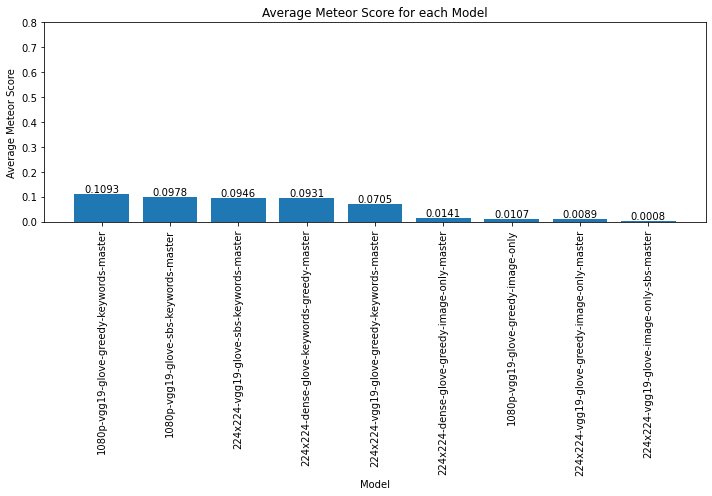

In [50]:
model_names = []
average_similarities = []

# Iterate through the subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        csv_path = os.path.join(subfolder_path, "sem_meteor.csv")

        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            average_similarity = df['sem_meteor'].mean()
            model_names.append(dir_name)
            average_similarities.append(average_similarity)

sort_indices = np.argsort(average_similarities)[::-1]
sorted_model_names = [model_names[i] for i in sort_indices]
sorted_average_similarities = [average_similarities[i] for i in sort_indices]

# Plotting the bar chart
plt.figure(figsize=(10,7))
plt.bar(sorted_model_names, sorted_average_similarities)
plt.xlabel("Model")
plt.ylabel("Average Meteor Score")
plt.title("Average Meteor Score for each Model")
plt.xticks(rotation=90)
# Add numerical values to each bar
for i, v in enumerate(sorted_average_similarities):
    plt.text(i, v, str(round(v, 4)), ha="center", va="bottom")

plt.ylim(0, 0.8)

plt.tight_layout()
#plt.savefig("plots/meteor_barplot.png", dpi=150)
plt.show()

- Semantic Meteor shows the same picture as with semantic similarity
- describe it very briefly

### F1

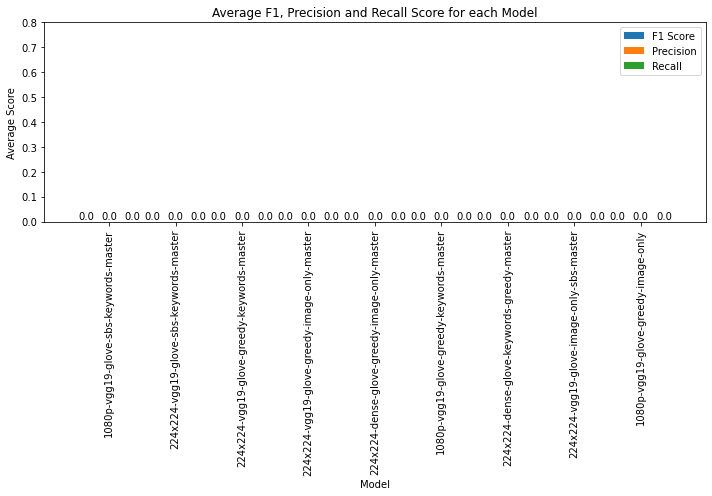

In [61]:
model_names = []
average_similarities = []
avg_ps = []
avg_rs = []

# Iterate through the subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        csv_path = os.path.join(subfolder_path, "traditional_scores.csv")

        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            average_similarity = df['f1'].mean()
            avg_p = df['p'].mean()
            avg_r = df['r'].mean()
            model_names.append(dir_name)
            average_similarities.append(average_similarity)
            avg_ps.append(avg_p)
            avg_rs.append(avg_r)

sort_indices = np.argsort(average_similarities)[::-1]
sorted_model_names = [model_names[i] for i in sort_indices]
sorted_average_similarities = [average_similarities[i] for i in sort_indices]
sorted_average_p = [avg_ps[i] for i in sort_indices]
sorted_average_r = [avg_rs[i] for i in sort_indices]

bar_width = 0.35
index = np.arange(len(sorted_model_names))

# Plotting the bar chart
plt.figure(figsize=(10,7))
plt.bar(index, sorted_average_similarities, bar_width, label="F1 Score")
plt.bar(index + bar_width, sorted_average_p, bar_width, label="Precision")
plt.bar(index - bar_width, sorted_average_r, bar_width, label="Recall")
plt.xlabel("Model")
plt.ylabel("Average Score")
plt.title("Average F1, Precision and Recall Score for each Model")
plt.xticks(index, sorted_model_names, rotation=90)
# Add numerical values to each bar
for i, v in enumerate(sorted_average_similarities):
    plt.text(i, v, str(round(v, 4)), ha="center", va="bottom")

for i, v in enumerate(sorted_average_p):
    plt.text(i + bar_width, v, str(round(v, 4)), ha="center", va="bottom")

for i, v in enumerate(sorted_average_r):
    plt.text(i - bar_width, v, str(round(v, 4)), ha="center", va="bottom")

plt.ylim(0, 0.8)

plt.tight_layout()
plt.legend()
#plt.savefig("plots/traditional_scores_f1_barplot.png", dpi=150)
plt.show()

- In terms of F1, Precision and Recall, all models achieved a Score of 0, showing that there is no meaningful overlap between the references and the model outputs

## Conclusion

- Models with keyword input performed a lot better than models without keyword input
- Simple Beam Search didn't yield better results, as the decoding strategy doesn't seem to be the bottleneck
- All models didn't perform at all in all metrics, with higher resolution keyword models showing the best performance
- Show model output examples of best model config and worst model config
- That shows that the decoder learned to produce a meaningful and good beginning of the question but the context seems to be missing as everything afterwards is basically rubbish
- The performance difference between the inclusion of keywords and no keywords hints at the fact that the image encoder is the bottle-neck of the architecture
- Even higher resolutions couldn't improve the results, showing that the resolution is in fact not the limiting factor at the moment
- Instead, the problem is the difference in training data for the image-encoder during pre-training and our data. Both models have been trained on Images of common objects and not texts or info graphics. We thus hypothesize, that the difference between the pre-trained weights and the theoretical optimal weights for our task is too large, and that our training procedure isn't sufficient to overcome this gap. Thus, it might be useful to retrain the image encoder from scratch with more data in a good pre-training task for future work. (Maybe also find a reference or an example that shows that visual understanding of textual content is difficult, even today?)